# Imports

In [1]:
# regular imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx


In [2]:
# mounting drive, so that the dataset will be downloaded there directly. 
# this is done since the dataset takes time to download and hence it is better to download it once and use it later directly once the session times out
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# changing directory
%cd /content/drive/MyDrive
PATH  = "/content/drive/MyDrive/DL_CIMON/"

/content/drive/MyDrive


In [4]:
# importing torchvison datasets, and other torchvision tools for image processing
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim

In [5]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [7]:
# Seeding for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Graph Generation

In [8]:
# Converting the images to tensors and normalizing them.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# The lines below are for downloading the dataset. If the dataset is downloaded already, then set the download=False

# training_data = datasets.STL10(
#     root="DL_CIMON",
#     split="train",
#     transform=transform,
#     download=False
# )

# test_data = datasets.STL10(
#     root="DL_CIMON",
#     split='test',
#     transform=transform,
#     download=False
# )

unlabeled = datasets.STL10(
    root="DL_CIMON",
    split="unlabeled",
    transform=transform,
    download=True
)

# train_plus_unlabeled = datasets.STL10(
#     root="DL_CIMON",
#     split="train+unlabeled",
#     transform=transform,
#     download=False
# )

Files already downloaded and verified


In [27]:
def inference(X, modelF):
    with torch.no_grad():
        out = modelF(X).squeeze(0)
        out = out.cpu().numpy()
        # out = out.cpu().detach().numpy()
        return out

def cos(a, b):
    out = np.dot(a, b)/max((np.linalg.norm(a)*np.linalg.norm(b)), 1e-7)
    return out

def computeSandDistances(v, t = 0.7):
    S = np.zeros((len(v), len(v)))
    distances = np.zeros((len(v), len(v)))
    for i in range(len(v)):
        for j in range(i, len(v)):
            if i == j:
                S[i][j] = S[j][i] = 1
                distances[i][j] = distances[j][i] = 0
                continue        
            output = 1 - cos(v[i], v[j])
            distances[i][j] = distances[j][i] = output
            S[i][j] = S[j][i] = 1 if (output <= t) else -1

    return S, distances

In [28]:
class modelF(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = models.vgg11_bn(pretrained=True)
        self.model.classifier = nn.Sequential(*[self.model.classifier[i] for i in range(4)]) # removing the last layers of the pretrained model
    def forward(self, x):
        return self.model(x)

In [29]:
device = "cpu"
BATCH_SIZE = 32
N_CLUSTERS = 4

In [30]:
torch.cuda.empty_cache()
f = modelF().to(device)

X = torch.cat([unlabeled[i][0].unsqueeze(0) for i in range(BATCH_SIZE)], dim = 0).to(device)
# print(X.shape)
# saveInference(X, f, PATH+"inferences")
a = inference(X, f)
S, d = computeSandDistances(a)
clustering = SpectralClustering(n_clusters=N_CLUSTERS)
print(S)
labels = clustering.fit_predict(S)
print(labels)


[[ 1. -1. -1. ...  1.  1. -1.]
 [-1.  1. -1. ...  1. -1. -1.]
 [-1. -1.  1. ... -1. -1. -1.]
 ...
 [ 1.  1. -1. ...  1.  1. -1.]
 [ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1.  1.]]
[2 2 1 1 0 1 1 1 0 1 2 0 1 1 3 2 0 0 0 1 3 1 3 0 1 3 0 3 2 2 3 1]


# Output

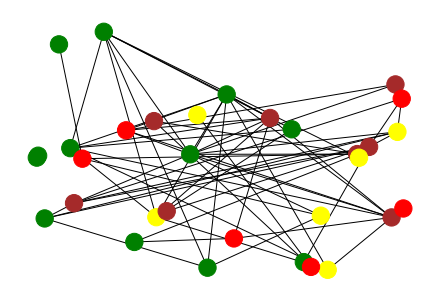

In [33]:
g = nx.Graph()
listg = S.tolist()
flag =  [False for i in range(BATCH_SIZE)]
# print(listg)
for i in range(BATCH_SIZE):
  for j in range(BATCH_SIZE):
    if listg[i][j] == 1:
      if i == j:
        g.add_node(i)
      else:
        g.add_edge(i,j)
      # flag[i] = True
      # flag[j] = True
# g.add_edge(1, 2)
# g.add_edge(2, 1)
# g.add_edge(2, 3)
# g.add_edge(3, 4)
# g.add_edge(1, 4)
# g.add_edge(1, 5)
# g.add_edge(5, 6)
# g.add_edge(5, 7)
# g.add_edge(4, 8)
# g.add_edge(3, 8)

color_map = []
for i in range(len(labels)):
    # if flag[i] == False:
    #   color_map.append('None')
    if labels[i] == 0:
        color_map.append('brown')
    elif labels[i] == 1: 
        color_map.append('green')
    elif labels[i] == 2: 
        color_map.append('yellow')
    elif labels[i] == 3: 
        color_map.append('red')
    else: 
        color_map.append('pink')        
nx.draw_random(g, node_color=color_map, with_labels=False)